# MOWNiT

 Użycie wielomianów ortogonalnych do analizy EKG 

Instalacja wymaganych pakietów

In [22]:
using Pkg

In [23]:
# Pkg.add("Polynomials")
# Pkg.add("SpecialPolynomials")
# Pkg.add("Plots")
# Pkg.add("CSV")
# Pkg.add("DataFrames")

In [24]:
# Pkg.build("Plots")

In [25]:
using Polynomials
using SpecialPolynomials
using Plots
using LinearAlgebra
using CSV
using DataFrames

## Teoria

**Wielomiany ortogonalne** to rodzina wielomianów, w których iloczyn skalarny dwóch róznych wielomianów jest równa 0.

Jeżeli dodatkowo iloczyn skalarny wielomianu "przez siebie" jest równy 1, to nazywamy je **wielomianami ortonormalnymi**

Iloczyn skalarny wielomianów można zdefiniować jako:

$<P_m,P_n>=\int_a^b P_n(x)P_m(x)W(x)dx = 0$

Funkcja *W* jest nazywana *funkcją wagową*.

### Przykładowe rodziny wielomianów ortogonalnych

| Nazwa                | Przedział       | Funkcja wagowa           | Zastosowanie                                           | Parzystość                                                     |
|----------------------|-----------------|--------------------------|--------------------------------------------------------|----------------------------------------------------------------|
| Czebyszewa (1 rzędu) | [-1,1]          | $\frac{1}{\sqrt{1-x^2}}$ | Zera wielomianu jako węzły interpolacji wielomianowej  | Dla parzystego k - parzyste, dla nieparzystego k - nieparzyste |
| Legendre             | [-1,1]          | 1                        | Zera wielomianu jako węzły kwadratur Gaussa-Legendre'a | jw                                                             |
| Hermite              | [$-\infty$,$\infty$] | $\exp(-x^2)$             | Zera wielomianu jako węzły kwadratur Gaussa-Hermite'a  | jw                                                             |
| Laguerre             | [0,$\infty$]      | $\exp(-x)$               | Zera wielomianu jako węzły kwadratur Gaussa-Laguerra'a | brak                                                           |


### Wielomiany Hermite'a

Zdefiniowane są rekurencyjnie jako:

$H_0(x) = 1$

$H_1(x) = 2x$

$H_{n+1}(x) = 2xH_n(x)-2nH_{n-1}$

Wykres przykładowego wielomianu (tutaj 3 stopnia)

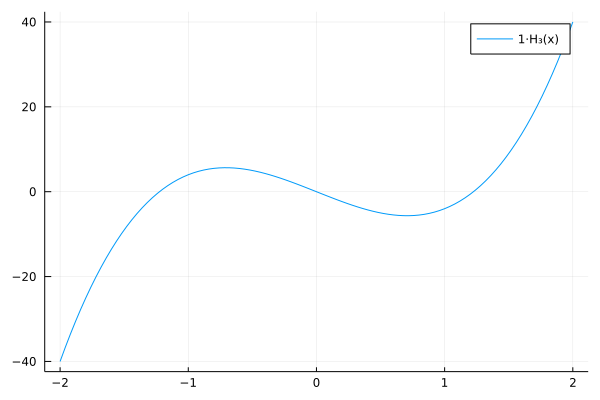

In [26]:
h3 = Hermite([0, 0, 0, 1])
plot(h3, -2, 2)

Żeby nie podawać wektora ze współczynnikami kolejnych stopni, można zrobić inaczej

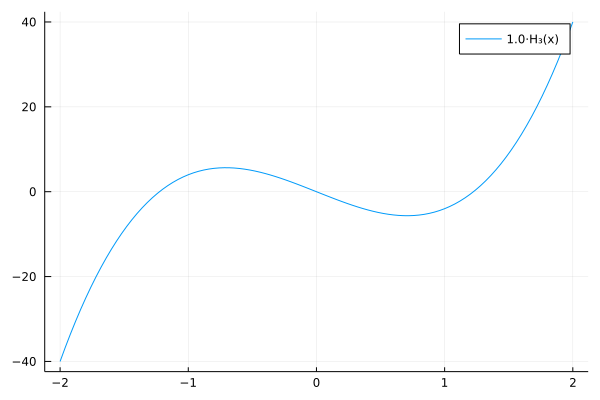

In [27]:
h4 = basis(Hermite, 3)
plot(h4, -2, 2)

### Przykład aproksymacji

Spróbujemy dokonać aproksymacji zaszumionej funkcji `cos` wykorzystując rodzinę wielomianów ortogonalnych Hermite'a.

In [28]:
# Definicja węzłów
xx = -5:.1:5
yy = cos.(xx/3 .+.2).^2 .+ rand(length(xx))/5;

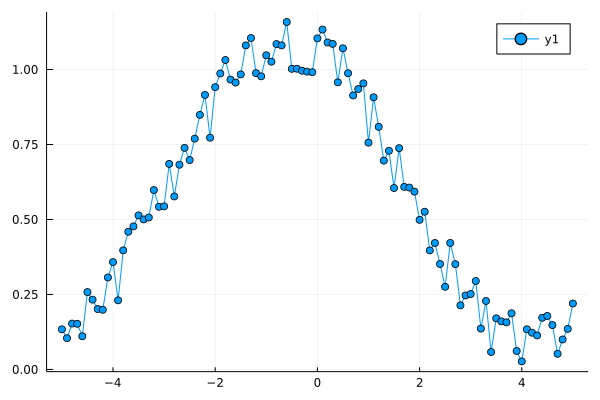

In [29]:
plot(xx, yy, markershape=:circle)

Obliczony wektor wartości normalizujemy do 1, żeby łatwiej policzyć współczynniki aproksymacji (niżej objaśnienie dlaczego łatwiej). 

In [30]:
#przykład prostego wektora, który znormalizujemy
vec=[2,2,2,2]

4-element Array{Int64,1}:
 2
 2
 2
 2

In [31]:
# iloczyn skalarny = długość^2
dot(vec,vec)

16

In [32]:
# normalizacja - długość wektora =1
normalize(vec)

4-element Array{Float64,1}:
 0.5
 0.5
 0.5
 0.5

In [33]:
# sprawdzamy długość^2
dot(normalize(vec), normalize(vec))

1.0

* 0bliczamy funkcję bazową uwzględniającą czynnik wagowy.
$<P_m,P_n>=\int_{-\infty}^{\infty} H_n(x)H_m(x)\exp(-x^2)dx 
= \int_{-\infty}^{\infty}\underbrace{H_n(x)\exp(-\frac{x^2}{2})}_{\text{funkcja bazowa}_n}\underbrace{H_m(x)\exp(-\frac{x^2}{2})}_{\text{funkcja bazowa}_m}$

* Wyliczamy jej wartości dla podanych punktów x
* Otrzymany wektor wartości normalizujemy


In [34]:
# obliczamy funkcję bazową
# argument 'norm'  na potrzeby wykresów
function base_fun(k, x, norm=true)
    H_k = basis(Hermite, k).(x)
    app = H_k .* exp.(-(x.^2)/2)
    # normalize to have norm 1
    if norm
        return normalize(app)
    end
    return app
end

base_fun (generic function with 2 methods)

In [35]:
y_2_unnorm = base_fun(2, xx, false);
y_2_norm = base_fun(2, xx);

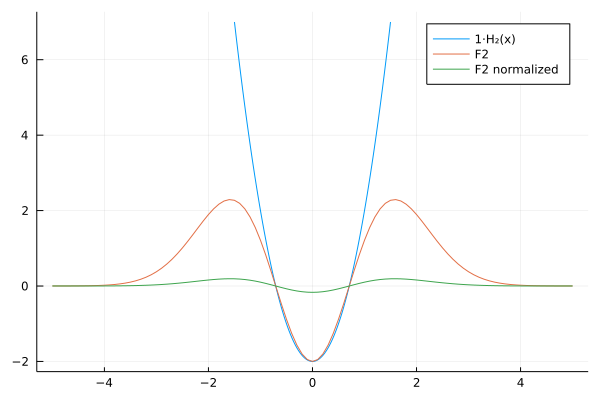

In [36]:
plot(Hermite([0, 0, 1]), -1.5, 1.5)
plot!(xx, y_2_unnorm, label="F2")
plot!(xx, y_2_norm, label="F2 normalized")

Obliczamy wektory wartosci dla punktów w xx dla kilku kolejnych funkcji bazowych

In [37]:
f0 = base_fun(0, xx, true);
f1 = base_fun(1, xx, true);
f2 = base_fun(2, xx, true);
f3 = base_fun(3, xx, true);

Sprawdźmy czy baza jest ortonormalna (uwaga: zamiast liczyć całkę, sprawdzamy po prostu iloczyn skalarny wektorów wartości)

In [38]:
dot_base = Array{Float64, 2}(undef, 4, 4); 

for (i, f_i) in enumerate([f0, f1, f2, f3]) 
    for (j, f_j) in enumerate([f0, f1, f2, f3])
        dot_base[i,j] = dot(f_i, f_j)
    end
end

In [39]:
dot_base

4×4 Array{Float64,2}:
  1.0           7.4436e-18   -3.25356e-11   5.32557e-18
  7.4436e-18    1.0           1.88742e-17  -9.61163e-10
 -3.25356e-11   1.88742e-17   1.0          -7.22228e-18
  5.32557e-18  -9.61163e-10  -7.22228e-18   1.0

OK, baza jest ortonormalna

Obliczamy kolejne współczynniki aproksymacji. Dzięki ortonormalnej bazie, poszczególne współczynniki są iloczynami skalarnymi wektora wartości funkcji aproksymowanej oraz  wektora bazowego (analogia: rzut  wektora wartości funkcji aproksymowanej w kierunku wektora bazowego).

Wektor bazowy jest znormalizowany $|\vec{j}|=1$, co upraszcza obliczenia.

Analogia w 2D

$\text{rzut }\vec{a} \text{ w kierunku }  \vec{j} =|\vec{a}|\cdot cos(\angle(\vec{a},\vec{j}))=|\vec{a}|\cdot|\vec{j}|\cdot cos(\angle(\vec{a},\vec{j}))=dot(\vec{a},\vec{j})$

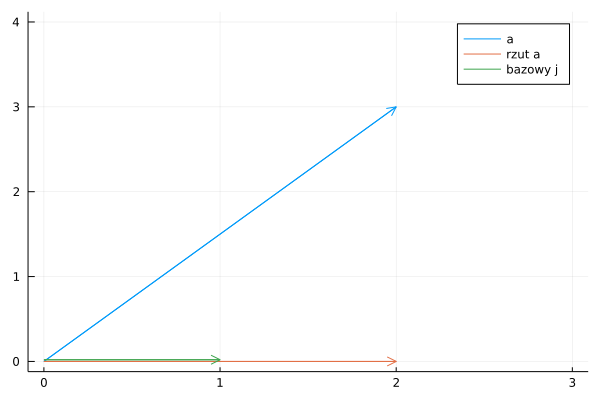

In [40]:
plot([0,2],[0,3],xrange=[0,3], yrange=[0,4],arrow=true, label="a")
plot!([0,2],[0,0],xrange=[0,3], yrange=[0,4],arrow=true, label="rzut a")
plot!([0,1],[0.02,0.02],xrange=[0,3], yrange=[0,4],arrow=true, label="bazowy j")

In [41]:
c0 = dot(yy, f0)
c1 = dot(yy, f1)
c2 = dot(yy, f2)
c3 = dot(yy, f3)
c0, c1, c2, c3

(5.7466162054109455, -0.7567049961292357, 2.720626322323846, -0.8866576741669676)

Liczymy wartości aproksymowane kolejnymi stopniami

In [42]:
y_app_0 = c0*f0;
y_app_1 = c1*f1;
y_app_2 = c2*f2;
y_app_3 = c3*f3;

In [43]:
y_app_01 = y_app_0 + y_app_1;
y_app_012 = y_app_01 + y_app_2;
y_app_0123 = y_app_012 + y_app_3;

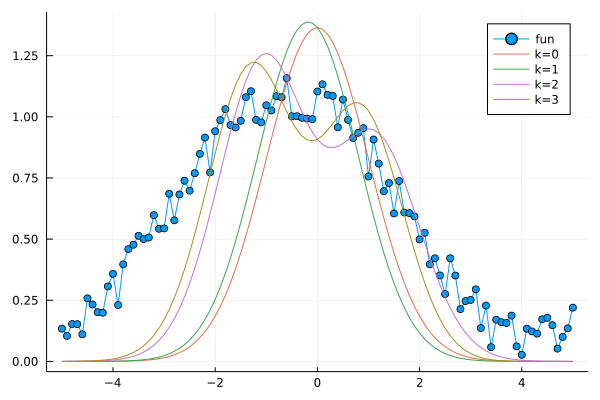

In [44]:
plot(xx, yy, markershape=:circle, label="fun")
plot!(xx, y_app_0, label="k=0")
plot!(xx, y_app_01, label="k=1")
plot!(xx, y_app_012, label="k=2")
plot!(xx, y_app_0123, label="k=3")

Liczymy błędy aproksymacji kolejnymi stopniami

In [45]:
using Statistics

In [46]:
mse(y1, y2) = mean((y1-y2).^2)

mse (generic function with 1 method)

In [47]:
mse(yy, y_app_0)

0.13236859899599704

In [48]:
mse(yy, y_app_01)

0.1266992677963243

In [49]:
mse(yy, y_app_012)

0.053414044165247795

In [50]:
mse(yy, y_app_0123)

0.04563026364595138

### EKG

Dane pochodzą z bazy https://www.physionet.org/content/mitdb/1.0.0/ .

W sygnale można wyróżnić wiele struktur, z których najbardziej charakterystyczną jest zespół QRS.

In [51]:
ekg_data = CSV.read("ecg_data.csv", DataFrame);

In [52]:
first(ekg_data, 5)

,time,signalN,signalV
,Float64,Float64,Float64
1,-0.1,0.0183886,-0.0990972
2,-0.0972222,0.0145191,-0.0920442
3,-0.0944444,0.012849,-0.0831644
4,-0.0916667,0.0124946,-0.0722728
5,-0.0888889,0.0124117,-0.0593656


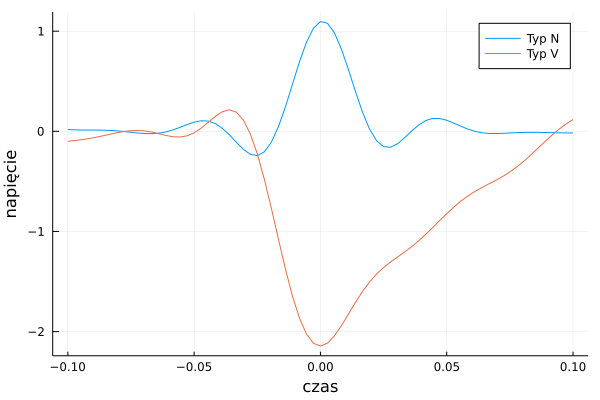

In [53]:
plot(ekg_data.time, ekg_data.signalN, label="Typ N", xlabel = "czas", ylabel="napięcie")
plot!(ekg_data.time, ekg_data.signalV, label="Typ V")

(5.725113911598116, -0.9157906158817669, 2.711325477169205, -0.8018390195854078)

Uwaga: Funkcje bazowe mają pewną "szerokość" i najlepiej aproksymują inne funkcje o podobnej szerokości. Można dodatkowo sparametryzować f. bazowe aby były węższe i lepiej pasowały do zespołów QRS. Na potrzeby laboratorium postąpimy inaczej - przeskalujemy oś X aproksymowanych sygnałów.

In [54]:
# Definicja węzłów
xx_ekg = ekg_data.time*40
yy_ekgV = ekg_data.signalV;

## Zadania

#### Zadanie 1 (1 pkt)

Narysować 6 pierwszych wielomianów Hermita (na jednym wykresie albo siatce 2x3 lub 3x2)

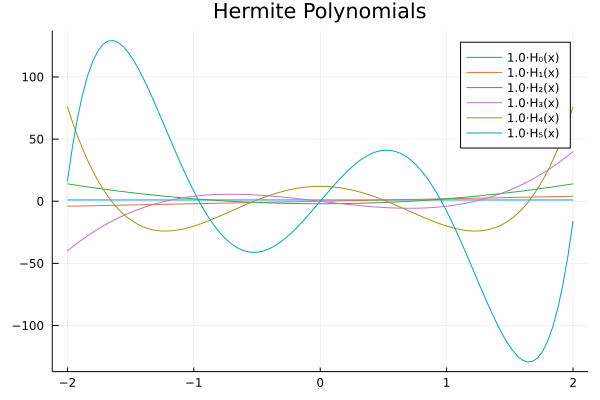

In [55]:
h0 = basis(Hermite, 0)
h1 = basis(Hermite, 1)
h2 = basis(Hermite, 2)
h3 = basis(Hermite, 3)
h4 = basis(Hermite, 4)
h5 = basis(Hermite, 5)

plot(h0, -2, 2, title="Hermite Polynomials")
plot!(h1, -2, 2)
plot!(h2, -2, 2)
plot!(h3, -2, 2)
plot!(h4, -2, 2)
plot!(h5, -2, 2)

#### Zadanie 2  (1 pkt)

Narysować 6 pierwszych funkcji aproksymujących

In [105]:
# wektory wartosci dla sześciu kolejnych funkcji bazowych

f0 = base_fun(0, xx, true);
f1 = base_fun(1, xx, true);
f2 = base_fun(2, xx, true);
f3 = base_fun(3, xx, true);
f4 = base_fun(4, xx, true);
f5 = base_fun(5, xx, true);

In [106]:
# kolejne współczynniki aproksymacji

c0 = dot(yy, f0)
c1 = dot(yy, f1)
c2 = dot(yy, f2)
c3 = dot(yy, f3)
c4 = dot(yy, f4)
c5 = dot(yy, f5)

c0, c1, c2, c3, c4, c5

(5.7466162054109455, -0.7567049961292357, 2.720626322323846, -0.8866576741669676, 1.5313019366469984, -0.5024612873957749)

In [107]:
# wartości aproksymowane kolejnymi stopniami

y_app_0 = c0*f0;
y_app_1 = c1*f1;
y_app_2 = c2*f2;
y_app_3 = c3*f3;
y_app_4 = c4*f4;
y_app_5 = c5*f5;

In [108]:
y_app_01 = y_app_0 + y_app_1;
y_app_012 = y_app_01 + y_app_2;
y_app_0123 = y_app_012 + y_app_3;
y_app_01234 = y_app_0123 + y_app_4;
y_app_012345 = y_app_01234 + y_app_5;

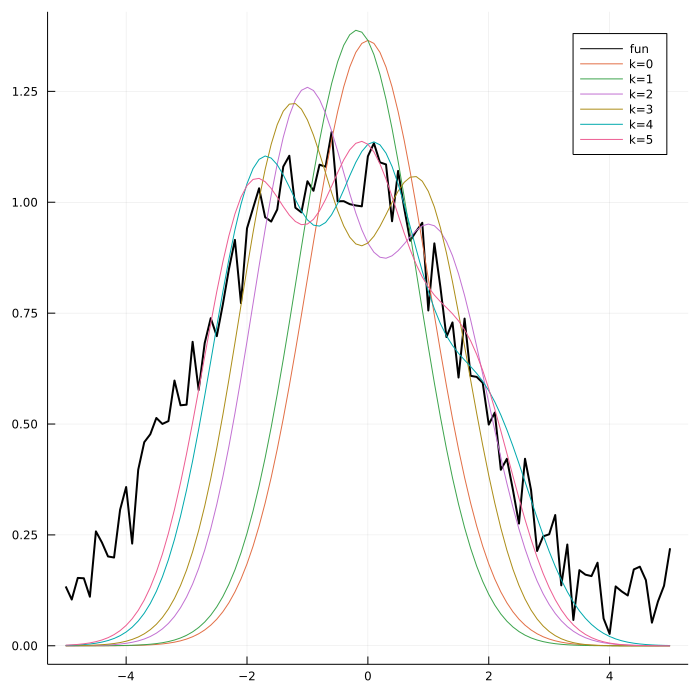

In [109]:
plot(xx, yy, label="fun", size = (700, 700), color="black", linewidth = 2)
plot!(xx, y_app_0, label="k=0")
plot!(xx, y_app_01, label="k=1")
plot!(xx, y_app_012, label="k=2")
plot!(xx, y_app_0123, label="k=3")
plot!(xx, y_app_01234, label="k=4")
plot!(xx, y_app_012345, label="k=5")

#### Zadanie 3  (1 pkt)

Pokazać, że same wielomiany nie są ortogonalne, ale już z funkcją wagową $exp(-x^2)$ są. Uzyć metody z wektorami wartości, założyć pewien przedział.

In [110]:
# ???

#### Zadanie 4  (1 pkt)

Dokonać aproksymacji zespołu QRS typu N oraz V za pomocą kilku kolejnych stopni. Przedstawić osobno wykresy dla N i V.

In [111]:
# Definicja węzłów

xx_ekg = ekg_data.time*40
yy_ekgN = ekg_data.signalN
yy_ekgV = ekg_data.signalV

73-element Array{Float64,1}:
 -0.09909715779999999
 -0.09204421709999999
 -0.08316443329999999
 -0.07227278155
 -0.05936556109999999
 -0.04477750854999999
 -0.029327795299999994
 -0.014377006100000006
 -0.0017530694999999819
  0.006518225149999987
  0.008652436999999999
  0.003670777900000019
 -0.008060976949999993
  ⋮
 -0.48882609635000007
 -0.4497784643
 -0.40562892815000007
 -0.3550052062000001
 -0.2977652177
 -0.23502230790000003
 -0.16892792204999998
 -0.10228938265
 -0.03807120239999999
  0.021100471150000008
  0.07334784450000001
  0.11779353039999998

#### Aproksymacja zespołu QRS typu N za pomocą 5 kolejnych stopni

In [112]:
# wektory wartosci dla kolejnych funkcji bazowych

f0 = base_fun(0, xx_ekg, true);
f1 = base_fun(1, xx_ekg, true);
f2 = base_fun(2, xx_ekg, true);
f3 = base_fun(3, xx_ekg, true);
f4 = base_fun(4, xx_ekg, true);

In [113]:
# kolejne współczynniki aproksymacji

c0 = dot(yy_ekgN, f0)
c1 = dot(yy_ekgN, f1)
c2 = dot(yy_ekgN, f2)
c3 = dot(yy_ekgN, f3)
c4 = dot(yy_ekgN, f4)

c0, c1, c2, c3, c4

(1.86013312787569, 0.2282900005244854, -1.193349646643517, -0.1137264199411359, 1.1523105429771954)

In [114]:
# wartości aproksymowane kolejnymi stopniami

y_app_0 = c0*f0;
y_app_1 = c1*f1;
y_app_2 = c2*f2;
y_app_3 = c3*f3;
y_app_4 = c4*f4;

In [115]:
y_app_01 = y_app_0 + y_app_1;
y_app_012 = y_app_01 + y_app_2;
y_app_0123 = y_app_012 + y_app_3;
y_app_01234 = y_app_0123 + y_app_4;

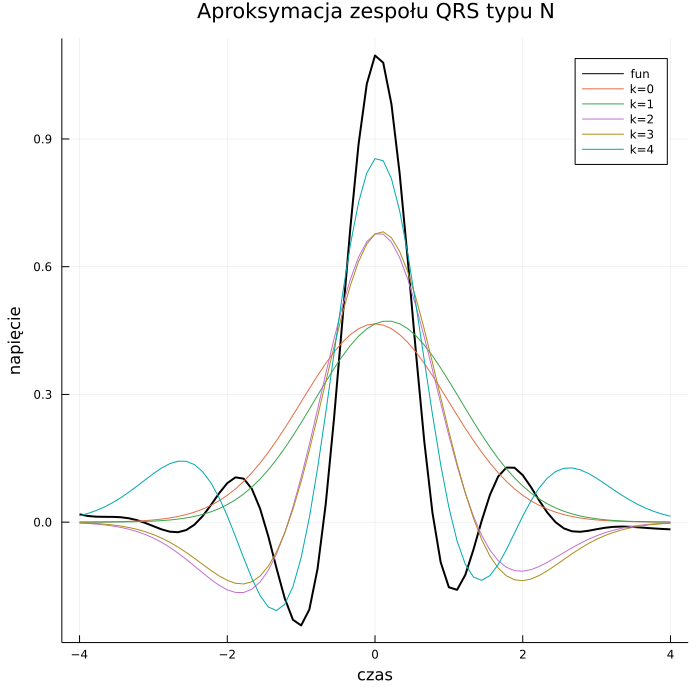

In [116]:
plot(xx_ekg, yy_ekgN, size = (700, 700), label="fun", color="black", title="Aproksymacja zespołu QRS typu N", 
    xlabel = "czas", ylabel="napięcie", linewidth = 2)
plot!(xx_ekg, y_app_0, label="k=0")
plot!(xx_ekg, y_app_01, label="k=1")
plot!(xx_ekg, y_app_012, label="k=2")
plot!(xx_ekg, y_app_0123, label="k=3")
plot!(xx_ekg, y_app_01234, label="k=4")

#### Aproksymacja zespołu QRS typu N za pomocą 5 kolejnych stopni

In [117]:
# wektory wartosci dla sześciu kolejnych funkcji bazowych

f0 = base_fun(0, xx_ekg, true);
f1 = base_fun(1, xx_ekg, true);
f2 = base_fun(2, xx_ekg, true);
f3 = base_fun(3, xx_ekg, true);
f4 = base_fun(4, xx_ekg, true);

In [118]:
# kolejne współczynniki aproksymacji

c0 = dot(yy_ekgV, f0)
c1 = dot(yy_ekgV, f1)
c2 = dot(yy_ekgV, f2)
c3 = dot(yy_ekgV, f3)
c4 = dot(yy_ekgV, f4)

c0, c1, c2, c3, c4

(-7.255529706029363, -2.7748846288984255, 0.3203648727028115, -1.2252240985974192, -1.5685873089778273)

In [119]:
# wartości aproksymowane kolejnymi stopniami

y_app_0 = c0*f0;
y_app_1 = c1*f1;
y_app_2 = c2*f2;
y_app_3 = c3*f3;
y_app_4 = c4*f4;

In [103]:
y_app_01 = y_app_0 + y_app_1;
y_app_012 = y_app_01 + y_app_2;
y_app_0123 = y_app_012 + y_app_3;
y_app_01234 = y_app_0123 + y_app_4;

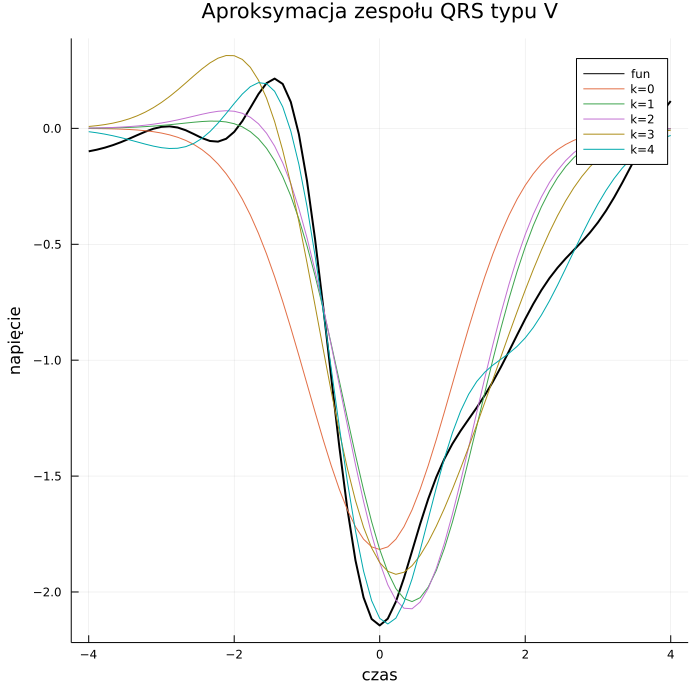

In [104]:
plot(xx_ekg, yy_ekgV, size = (700, 700), label="fun", color="black", title="Aproksymacja zespołu QRS typu V", 
    xlabel = "czas", ylabel="napięcie", linewidth = 2)
plot!(xx_ekg, y_app_0, label="k=0")
plot!(xx_ekg, y_app_01, label="k=1")
plot!(xx_ekg, y_app_012, label="k=2")
plot!(xx_ekg, y_app_0123, label="k=3")
plot!(xx_ekg, y_app_01234, label="k=4")

#### Zadanie 5  (1 pkt)

Przedstawić wykres błędu aproksymacji w zależności od stopnia wielomianu dla stopni od 0 do 10. Jakiego stopnia należy użyć gdybyśmy mieli robić coś dalej z rezultatem aproksymacji?

Użyłam powyższej aproksymacji zespołu QRS typu V.

In [172]:
f0 = base_fun(0, xx_ekg)
f1 = base_fun(1, xx_ekg)
f2 = base_fun(2, xx_ekg)
f3 = base_fun(3, xx_ekg)
f4 = base_fun(4, xx_ekg)
f5 = base_fun(5, xx_ekg)
f6 = base_fun(6, xx_ekg)
f7 = base_fun(7, xx_ekg)
f8 = base_fun(8, xx_ekg)
f9 = base_fun(9, xx_ekg)
f10 = base_fun(10, xx_ekg)

73-element Array{Float64,1}:
  0.20612885672109554
  0.19032955374252405
  0.1608499880397874
  0.11816778922861801
  0.06463239865900997
  0.004579508675948845
 -0.05588932074693531
 -0.10951767215995427
 -0.14888028094651798
 -0.16763757867835244
 -0.16185971253758794
 -0.13115076587646615
 -0.07928162775056127
  ⋮
 -0.13115076587646615
 -0.1618597125375864
 -0.16763757867835302
 -0.14888028094652034
 -0.10951767215995802
 -0.05588932074693993
  0.004579508675943996
  0.06463239865900533
  0.11816778922861407
  0.16084998803978454
  0.19032955374252228
  0.2061288567210948

In [173]:
y_app_0 = dot(yy_ekgV, f0)*f0;
y_app_1 = dot(yy_ekgV, f1)*f1;
y_app_2 = dot(yy_ekgV, f2)*f2;
y_app_3 = dot(yy_ekgV, f3)*f3;
y_app_4 = dot(yy_ekgV, f4)*f4;
y_app_5 = dot(yy_ekgV, f5)*f5;
y_app_6 = dot(yy_ekgV, f6)*f6;
y_app_7 = dot(yy_ekgV, f7)*f7;
y_app_8 = dot(yy_ekgV, f8)*f8;
y_app_9 = dot(yy_ekgV, f9)*f9;
y_app_10 = dot(yy_ekgV, f10)*f10;

In [174]:
y_app_01 = y_app_0 + y_app_1;
y_app_012 = y_app_01 + y_app_2;
y_app_0123 = y_app_012 + y_app_3;
y_app_01234 = y_app_0123 + y_app_4;
y_app_012345 = y_app_01234 + y_app_5;
y_app_0123456 = y_app_012345 + y_app_6;
y_app_01234567 = y_app_0123456 + y_app_7;
y_app_012345678 = y_app_01234567 + y_app_8;
y_app_0123456789 = y_app_012345678 + y_app_9;
y_app_012345678910 = y_app_0123456789 + y_app_10;

In [175]:
mse(y_app) = mean((yy_ekgV-y_app).^2)

mse (generic function with 2 methods)

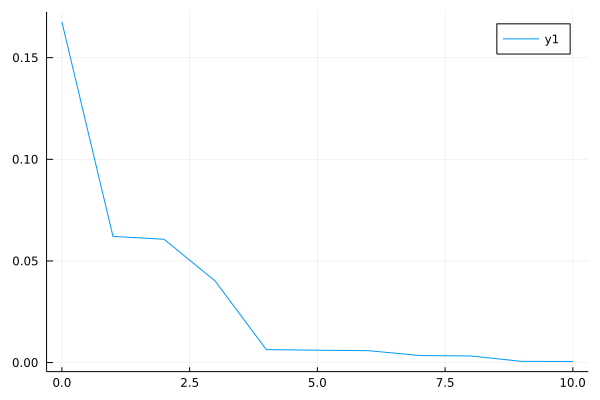

In [178]:
xx = 0:10
yy = [y_app_0, y_app_01, y_app_012, y_app_0123, y_app_01234, y_app_012345, 
    y_app_0123456, y_app_01234567, y_app_012345678, y_app_0123456789, y_app_012345678910]

plot(xx,[mse(y) for y in yy])

Od około 4 stopnia wielomianu błąd jest dostatecznie mały, by bez przeszkód móc wykorzystać rezultat aproksymacji.